## Named Entity Recognition (NER) is the process of determining which words in a set of text belong to a set of categories of special interest such as dates, organizations, people, etc.

## There are 9 broad categories
+ geo: geographical location
+ org: organization
+ per: person
+ gpe: geopolitical entity
+ tim: time indicator
+ art: artifact
+ eve: event
+ nat: natural phenomenon
+ o: other, not of interest (most words)

## Because entities can encompass multiple words we also need to denote the position of each. This is done by breaking each category (other than ```o```) into a sub-category using the prefix of either ```b``` (beginning) or ```i``` (inside). For instance the name Jan Egeland would have the tags b-per and i-per respectively.

In [1]:
import functools as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from typing import *

In [2]:
class Tokenizer:
    __slots__ = [
          'vocab_w'
        , 'vocab_i'
        , 'padder_w'
        , 'padder_i'
        , 'oov_w'
        , 'oov_i'
    ]

    def __init__(self, words: pd.Series):
        padder = '__PADDER__'
        oov = '__OOV__'
        w = pd.concat([words, pd.Series([padder, oov])])

        self.vocab_w = {x: i for i, x in enumerate(set(w))}
        self.vocab_i = {i: x for i, x in enumerate(set(w))}

        self.padder_w = padder
        self.padder_i = self.vocab_w[padder]

        self.oov_w = oov
        self.oov_i = self.vocab_w[oov]

In [3]:
def build_data(df: pd.DataFrame, x_tokens: Tokenizer, y_tokens: Tokenizer, pad_length: int) -> Tuple[np.array, np.array]:
    '''
    Formats sentence arrays into TF friendly numpy arrays.
    x: 2D array with each word replaced by its respective token.
    y: 3D array with each tag  replaced with a one-hot-encoded array.
    '''
    x = np.zeros((df.shape[0], pad_length))
    y = np.zeros((df.shape[0], pad_length, len(y_tokens.vocab_w)), dtype = 'byte')

    for i1, row in df.reset_index().iterrows():
        for i2 in range(pad_length):
            if i2 < row.WordCount:
                if x_tokens.vocab_w.get(row.Word[i2]):
                    x[i1, i2] = x_tokens.vocab_w[row.Word[i2]]
                    y[i1, i2, y_tokens.vocab_w[row.Tag[i2]]] = 1
                else:
                    x[i1, i2] = x_tokens.oov_i
                    y[i1, i2, y_tokens.oov_i] = 1
            else:
                x[i1, i2] = x_tokens.padder_i
                y[i1, i2, y_tokens.padder_i] = 1
    return x, y


def build_results(tokens: List[str], y_true: np.array, y_pred: np.array) -> List[List[object]]:
    '''Format the results of a model's y-hat response in comparison to the true y value for a pandas DataFrame.'''
    for tag in tokens:
        i_true = np.where(y_true == tag)[0]
        i_pred = y_pred[i_true]

        n_true = i_true.size
        n_pred = np.where(i_pred == tag)[0].size

        yield [tag, n_true, n_pred,  n_pred / n_true]


def plot_fit(fit) -> None:
    '''Plot the history of a TF model fit.'''
    pd.DataFrame(fit.history).plot(figsize = (8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

### Import the data and do some minor preprocessing to group words and tags by their respective sentence.
### Get the word count of each sentence to help later define the padding length needed to format the data for TensorFlow.

In [4]:
df = pd.read_csv(
      'https://raw.githubusercontent.com/amankharwal/Website-data/master/ner_dataset.csv'
    , encoding= 'unicode_escape'
).rename(
      {'Sentence #': 'Sentence'}
    , axis = 'columns'
).assign(
      Sentence = lambda df: df.Sentence.fillna(method = 'ffill')
    , Word = lambda df: df.Word.map(str.lower)
    , Tag = lambda df: df.Tag.map(str.lower)
).groupby(
      'Sentence'
    , as_index = False
).agg(
      list
).assign(
      WordCount = lambda df: df.Word.map(len)
)

df

,Sentence,Word,POS,Tag,WordCount
0,Sentence: 1,"[thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[o, o, o, o, o, o, b-geo, o, o, o, o, o, b-geo...",24
1,Sentence: 10,"[iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[b-gpe, o, o, o, o, o, o, o, o, o, o, o, o, o,...",25
2,Sentence: 100,"[helicopter, gunships, saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[o, o, b-tim, o, o, o, o, o, b-geo, o, o, o, o...",32
3,Sentence: 1000,"[they, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[o, o, o, o, o, o, o, o, o, o, o]",11
4,Sentence: 10000,"[u.n., relief, coordinator, jan, egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[b-geo, o, o, b-per, i-per, o, b-tim, o, b-geo...",35
...,...,...,...,...,...
47954,Sentence: 9995,"[opposition, leader, mir, hossein, mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[o, o, o, b-per, i-per, o, o, o, o, o, o, o, o...",32
47955,Sentence: 9996,"[on, thursday, ,, iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[o, b-tim, o, b-gpe, o, o, o, o, o, o, o, o, b...",25
47956,Sentence: 9997,"[following, iran, 's, disputed, june, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[o, b-geo, o, o, b-tim, i-tim, o, o, o, o, o, ...",27
47957,Sentence: 9998,"[since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",21


### Train test split for out test data before tokenization so we don't include test data into our Vocabulary and will need to account for Out of Vocaulary terms.

In [5]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 11)
df_train.shape, df_test.shape

((43163, 5), (4796, 5))

### Tokenization for words and tags

In [6]:
x_tokens = Tokenizer(df_train.Word.explode())
len(x_tokens.vocab_w)

30486

In [7]:
y_tokens = Tokenizer(df_train.Tag.explode())
len(y_tokens.vocab_w)

19

### Evaluate sentence length to include as much of the data as possible in our padding cutoff without making the majority of terms padding.

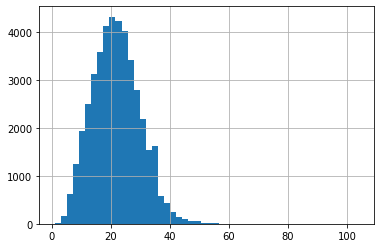

In [8]:
df_train.WordCount.hist(bins = 50)
plt.show()

In [9]:
max_length = 35

In [10]:
w = df.WordCount
w[w <= max_length].count() / w.count()

0.951104068058133

### Build TF friendly token arrays with padding.

In [11]:
build = F.partial(build_data, **{
      'x_tokens': x_tokens
    , 'y_tokens': y_tokens
    , 'pad_length': max_length
})
x_train, y_train = build(df_train)
x_test, y_test = build(df_test)

x_train.shape, y_train.shape

((43163, 35), (43163, 35, 19))

In [12]:
x_train[0], y_train[0]

(array([ 8167.,  5060., 12765., 12966., 28316., 17437., 20625.,  3152.,
        12927., 17580., 19425., 18605.,  8212.,  8120., 11938., 27252.,
        27252., 27252., 27252., 27252., 27252., 27252., 27252., 27252.,
        27252., 27252., 27252., 27252., 27252., 27252., 27252., 27252.,
        27252., 27252., 27252.]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        

### Train test split for training and validaiton sets.

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(
      x_train
    , y_train
    , test_size = 0.25
    , random_state = 11
)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((32372, 35), (10791, 35), (32372, 35, 19), (10791, 35, 19))

In [14]:
np.random.seed(11)
tf.random.set_seed(11)

In [15]:
dim_output = 64

### Build RNN.

In [56]:
model = tf.keras.Sequential([
    # Embedding
      tf.keras.layers.Embedding(
          input_dim = len(x_tokens.vocab_w)
        , output_dim = dim_output
        , input_length = max_length
    )
    
    # Bidrectional LSTM Layer 1
    , tf.keras.layers.Bidirectional(merge_mode = 'concat', layer = tf.keras.layers.LSTM(
          units = dim_output
        , return_sequences = True
        , dropout = 0.2
        , recurrent_dropout = 0.2
    ))

    # LSTM Layer 2
    , tf.keras.layers.LSTM(
          units = dim_output
        , return_sequences = True
        , dropout = 0.5
        , recurrent_dropout = 0.5
    )

    # Time Distributed Dense Output
    , tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
          units = len(y_tokens.vocab_w)
        , activation = 'softmax'
    ))
])

model.compile(
      loss = 'categorical_crossentropy'
    , optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    , metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 64)            1951104   
                                                                 
 bidirectional_1 (Bidirectio  (None, 35, 128)          66048     
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 35, 64)            49408     
                                                                 
 time_distributed_1 (TimeDis  (None, 35, 19)           1235      
 tributed)                                                       
                                                                 
Total params: 2,067,795
Trainable params: 2,067,795
Non-trainable params: 0
_________________________________________________________________


### Model checkpoints.

In [57]:
path_best = 'weights_NER.hdf5'

callbacks = [
      tf.keras.callbacks.ModelCheckpoint(
          path_best
        , monitor = 'val_accuracy'
        , save_best_only = True
        , mode = 'max'
    )
    , tf.keras.callbacks.EarlyStopping(
          monitor = 'val_accuracy'
        , patience = 3
    )
    , tf.keras.callbacks.ReduceLROnPlateau(
          monitor = 'val_accuracy'
        , factor = 0.7
        , patience = 2
        , min_lr = 0.001
    )
]

### Model fit.

Epoch 1/15
65/65 [==============================] - 93s 1s/step - loss: 0.5726 - accuracy: 0.8660 - val_loss: 0.2666 - val_accuracy: 0.9251 - lr: 0.0100
Epoch 2/15
65/65 [==============================] - 84s 1s/step - loss: 0.1935 - accuracy: 0.9458 - val_loss: 0.1374 - val_accuracy: 0.9642 - lr: 0.0100
Epoch 3/15
65/65 [==============================] - 79s 1s/step - loss: 0.1105 - accuracy: 0.9700 - val_loss: 0.1056 - val_accuracy: 0.9710 - lr: 0.0100
Epoch 4/15
65/65 [==============================] - 79s 1s/step - loss: 0.0835 - accuracy: 0.9763 - val_loss: 0.0988 - val_accuracy: 0.9722 - lr: 0.0100
Epoch 5/15
65/65 [==============================] - 80s 1s/step - loss: 0.0702 - accuracy: 0.9797 - val_loss: 0.0949 - val_accuracy: 0.9741 - lr: 0.0100
Epoch 6/15
65/65 [==============================] - 79s 1s/step - loss: 0.0611 - accuracy: 0.9819 - val_loss: 0.0978 - val_accuracy: 0.9741 - lr: 0.0100
Epoch 7/15
65/65 [==============================] - 79s 1s/step - loss: 0.0550 - a

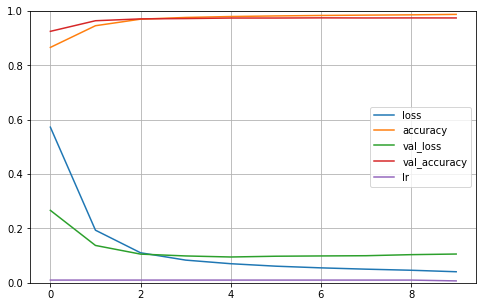

In [58]:
fit = model.fit(
      x = x_train
    , y = y_train
    , validation_data = (x_valid, y_valid)
    , callbacks = callbacks
    , batch_size = 500
    , epochs = 15
)
plot_fit(fit)

### Our model stops after 10 epochs with a 97.44% validation accuracy. Learning began plateauing early on both validation loss and accuracy. While we seem to have avoided overfitting less training would be fine.

In [35]:
# model_best = tf.keras.models.load_model(path_best)
# model_best.input_shape

### Evaluate model performance on validation data.

In [31]:
y_true = np.array([y_tokens.vocab_i[i] for i in np.argmax(y_valid, axis = -1).flatten()])
y_pred = np.array([y_tokens.vocab_i[i] for i in np.argmax(model.predict(x_valid), axis = -1).flatten()])

338/338 [==============================] - 14s 37ms/step


In [45]:
df_valid_results = pd.DataFrame(
      list(build_results(y_tokens.vocab_w.keys(), y_true, y_pred))
    , columns = ['Tag', 'True', 'Pred', 'Accuracy']
)
df_valid_results.style.background_gradient(
      cmap = 'RdBu'
    , vmin = 0
    , vmax = 1
    , subset = ['Accuracy']
)

,Tag,True,Pred,Accuracy
0,b-tim,4549,3932,0.864366
1,i-org,3600,2310,0.641667
2,i-nat,17,0,0.000000
3,i-geo,1687,1280,0.758743
4,__OOV__,1,0,0.000000
5,i-tim,1385,945,0.682310
6,__PADDER__,144274,144271,0.999979
7,i-art,62,0,0.000000
8,b-geo,8450,7264,0.859645
9,b-per,3785,2875,0.759577


### Evaluate model performance on test data.

In [36]:
test_true = np.array([y_tokens.vocab_i[i] for i in np.argmax(y_test, axis = -1).flatten()])
test_pred = np.array([y_tokens.vocab_i[i] for i in np.argmax(model.predict(x_test), axis = -1).flatten()])

150/150 [==============================] - 4s 27ms/step


In [54]:
df_test_results = pd.DataFrame(
      list(build_results(y_tokens.vocab_w.keys(), test_true, test_pred))
    , columns = ['Tag', 'True', 'Pred', 'Accuracy']
)
df_test_results.style.background_gradient(
      cmap = 'RdBu'
    , vmin = 0
    , vmax = 1
    , subset = ['Accuracy']
)

,Tag,True,Pred,Accuracy
0,b-tim,2023,1725,0.852694
1,i-org,1601,976,0.609619
2,i-nat,3,0,0.000000
3,i-geo,727,563,0.774415
4,__OOV__,1354,0,0.000000
5,i-tim,667,413,0.619190
6,__PADDER__,64548,64547,0.999985
7,i-art,23,0,0.000000
8,b-geo,3687,3272,0.887442
9,b-per,1661,1324,0.797110


### Compare validation and test results.
### We seem to have generalized well, the validation and test results are within a close range to one another and there are even cases of the model performing better on the test data than the validation data.

In [55]:
pd.DataFrame({
      'Tag': df_test_results.Tag
    , 'Validation Accuracy': df_valid_results.Accuracy
    , 'Test Accuracy': df_test_results.Accuracy
    , 'Test Accuracy Change': df_test_results.Accuracy - df_valid_results.Accuracy
}).style.background_gradient(
      cmap = 'RdBu'
    , vmin = 0
    , vmax = 1
    , subset = ['Validation Accuracy', 'Test Accuracy']
).background_gradient(
      cmap = 'RdBu'
    , vmin = -0.05
    , vmax = 0.05
    , subset = ['Test Accuracy Change']
)

,Tag,Validation Accuracy,Test Accuracy,Test Accuracy Change
0,b-tim,0.864366,0.852694,-0.011672
1,i-org,0.641667,0.609619,-0.032048
2,i-nat,0.000000,0.000000,0.000000
3,i-geo,0.758743,0.774415,0.015672
4,__OOV__,0.000000,0.000000,0.000000
5,i-tim,0.682310,0.619190,-0.063120
6,__PADDER__,0.999979,0.999985,0.000005
7,i-art,0.000000,0.000000,0.000000
8,b-geo,0.859645,0.887442,0.027797
9,b-per,0.759577,0.797110,0.037533
